In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [2]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.deterministic import DeterministicProcess

from prophet import Prophet
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM
from src.models.train_model import ModeloHibrido
from sklearn.linear_model import LinearRegression

from src.features import build_features
from src.models.predict_model import evaluar_desempeno_train_y_test_serie_tiempo

warnings.filterwarnings("ignore")

sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

c:\Users\ppizarro\AppData\Local\anaconda3\envs\int-proyeccion\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Objetivo del cuadernillo

En este cuadernillo se quiere realizar el preprocesamiento de los datos de egresos hospitalarios para confeccionar un modelo de previsión de esta métrica hasta el 2035. De forma general, se utilizarán los datos desde 2001 hasta 2018 para entrenar modelos, y 2019 para evaluar los modelos. Se obviará 2020 del análisis debido a la naturaleza del año (pandemia).

- Se entrenarán 6 modelos distintos, y se seleccionará el que tenga el mejor desempeño en el conjunto de evaluación (año 2019). Los modelos a entrenar serán:

  - Prophet
  - Auto ARIMA
  - XGB
  - Hibrido
  - Feed Forward Neural Network
  - Long-Short Term Memory (LSTM)

Para simplificar el modelamiento de los datos, se harán las predicciones con una agregación de egresos mensuales.


In [52]:
DIAGS_MAS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I350",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J398",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J90X",
    "J91X",
    "J931",
    "J955",
    "J980",
    "M348",
    "Q211",
    "Q231",
    "Q676",
    "T820",
    "T821",
    "Z450",
]

In [53]:
# Lee la base de datos
egresos_torax = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")

# Crea columna de fecha en datetime
egresos_torax["FECHA_EGRESO"] = pd.to_datetime(
    egresos_torax["ANO_EGRESO"].astype(str)
    + "-"
    + egresos_torax["MES_EGRESO"].astype(str)
    + "-"
    + egresos_torax["DIA_EGRESO"].astype(str),
    format="%Y-%m-%d",
)

# Elimina columnas redundantes
egresos_torax = egresos_torax.drop(
    columns=[
        "ANO_EGRESO",
        "MES_EGRESO",
        "DIA_EGRESO",
        "ESTABLECIMIENTO_SALUD",
        "GLOSA_ESTABLECIMIENTO_SALUD",
    ]
).sort_values("FECHA_EGRESO")

# Elimina el anio 2020, debido a que es anomalo (Pandemia COVID)
egresos_torax = egresos_torax.query("FECHA_EGRESO < '2020-01-01'")

# Elige la fecha como indice de los datos
egresos_torax = egresos_torax.set_index("FECHA_EGRESO")

# Filtra los egresos de los diags mas relevantes
egresos_torax_mas_relevantes = egresos_torax.query("DIAG1.isin(@DIAGS_MAS_RELEVANTES)")

In [54]:
# Obtiene metricas agregadas por mes (suma los egresos de todos los diags por dia)
df = egresos_torax.resample("M").sum()[["n_egresos"]]
df_relevantes = (
    egresos_torax_mas_relevantes
    .resample("M")
    .sum()[["n_egresos"]]
)

# 1. Preprocesamiento de los datos

Cada uno de los modelos requiere un preprocesamiento distinto de los datos. Por lo tanto, se creará un apartado para cada uno.


In [6]:
# Previo a cualquier preprocesamiento, se separa en train y test
CORTE_TEST = "2019-01-01"

train = df[df.index < CORTE_TEST]
test = df[df.index >= CORTE_TEST]

# Define time splitter para hacer validacion cruzada
time_splitter = TimeSeriesSplit(n_splits=5, test_size=12)

metricas = {
    "MAE": mean_absolute_error,
    "MAPE": mean_absolute_percentage_error,
}

## Prophet


In [7]:
# Preprocesa datos Prophet
train_prophet = train.reset_index().rename(columns={"FECHA_EGRESO": "ds", "n_egresos": "y"})
test_prophet = test.reset_index().rename(columns={"FECHA_EGRESO": "ds", "n_egresos": "y"})

In [8]:
# Entrena datos en Prophet
prophet = Prophet()
prophet.add_country_holidays("Chile")

# # Define the hyperparameters grid
# param_grid = {
#     "seasonality_mode": ["additive", "multiplicative"],
#     "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
#     # Add more hyperparameters here to tune
# }

# prophet = GridSearchCV(
#     estimator=prophet, param_grid=param_grid, scoring="neg_mean_absolute_error", cv=time_splitter
# )
prophet.fit(train_prophet)

09:15:46 - cmdstanpy - INFO - Chain [1] start processing
09:15:46 - cmdstanpy - INFO - Chain [1] done processing


Train
MAE: 27.53
MAPE: 0.07

Test
MAE: 35.46
MAPE: 0.08



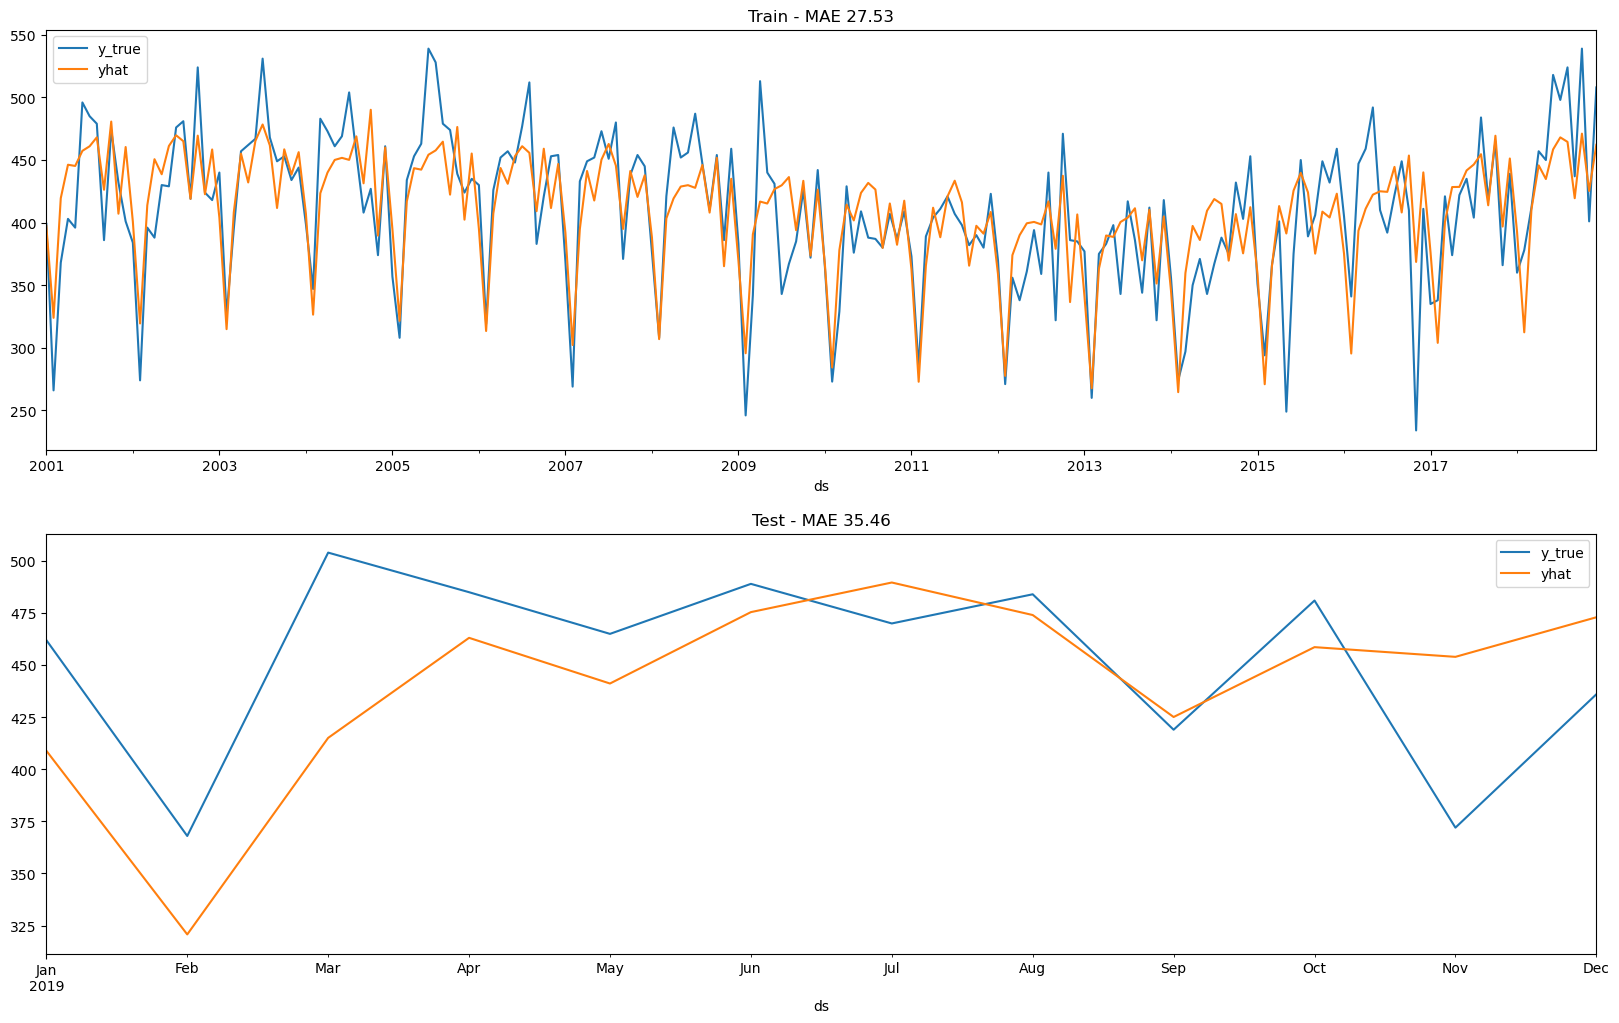

In [9]:
# Predice en conjunto de entrenamiento y testeo
yhat_train_prophet = prophet.predict(train_prophet)["yhat"]
yhat_test_prophet = prophet.predict(test_prophet)["yhat"]

resultados_prophet = evaluar_desempeno_train_y_test_serie_tiempo(
    train_prophet["ds"],
    train_prophet["y"],
    yhat_train_prophet,
    test_prophet["ds"],
    test_prophet["y"],
    yhat_test_prophet,
    metricas,
)

## Auto ARIMA


In [10]:
train_auto_arima = train["n_egresos"]
test_auto_arima = test["n_egresos"]

In [11]:
arima = auto_arima(
    train_auto_arima,
    start_p=1,
    d=1,
    start_q=1,
    max_p=5,
    max_d=5,
    max_q=5,
    m=12,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=5,
    max_D=5,
    max_Q=5,
    seasonal=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    n_fits=50,
    trace=True,
)

print(arima.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2152.011, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2239.530, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2155.577, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2084.254, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2153.062, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2084.848, Time=0.32 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2084.881, Time=0.33 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2114.501, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2164.901, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2084.217, Time=0.24 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2084.866, Time=0.38 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2084.834, Time=0.42 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2115.748, Time=0.18 sec
 ARIMA(1,1,1)(1,1,2)[12]

In [12]:
sarimax = SARIMAX(train_auto_arima, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
result_sarimax = sarimax.fit()
result_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          n_egresos   No. Observations:                  216
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1038.108
Date:                            Mon, 18 Dec 2023   AIC                           2084.217
Time:                                    09:15:53   BIC                           2097.470
Sample:                                01-31-2001   HQIC                          2089.578
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1393      0.090      1.540      0.124      -0.038       0.317
ma.L1         -0.8597      0.042    -20.241      0.000      -0.943      -0.776
ma.S.L12      -0.7569      0.061    -12.321      0.000      -0.877      -0.637
sigma2      1530.0092    123.309     12.408      0.000    1288.327    1771.691
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                75.74
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train
MAE: 34.48
MAPE: 0.09

Test
MAE: 32.34
MAPE: 0.07



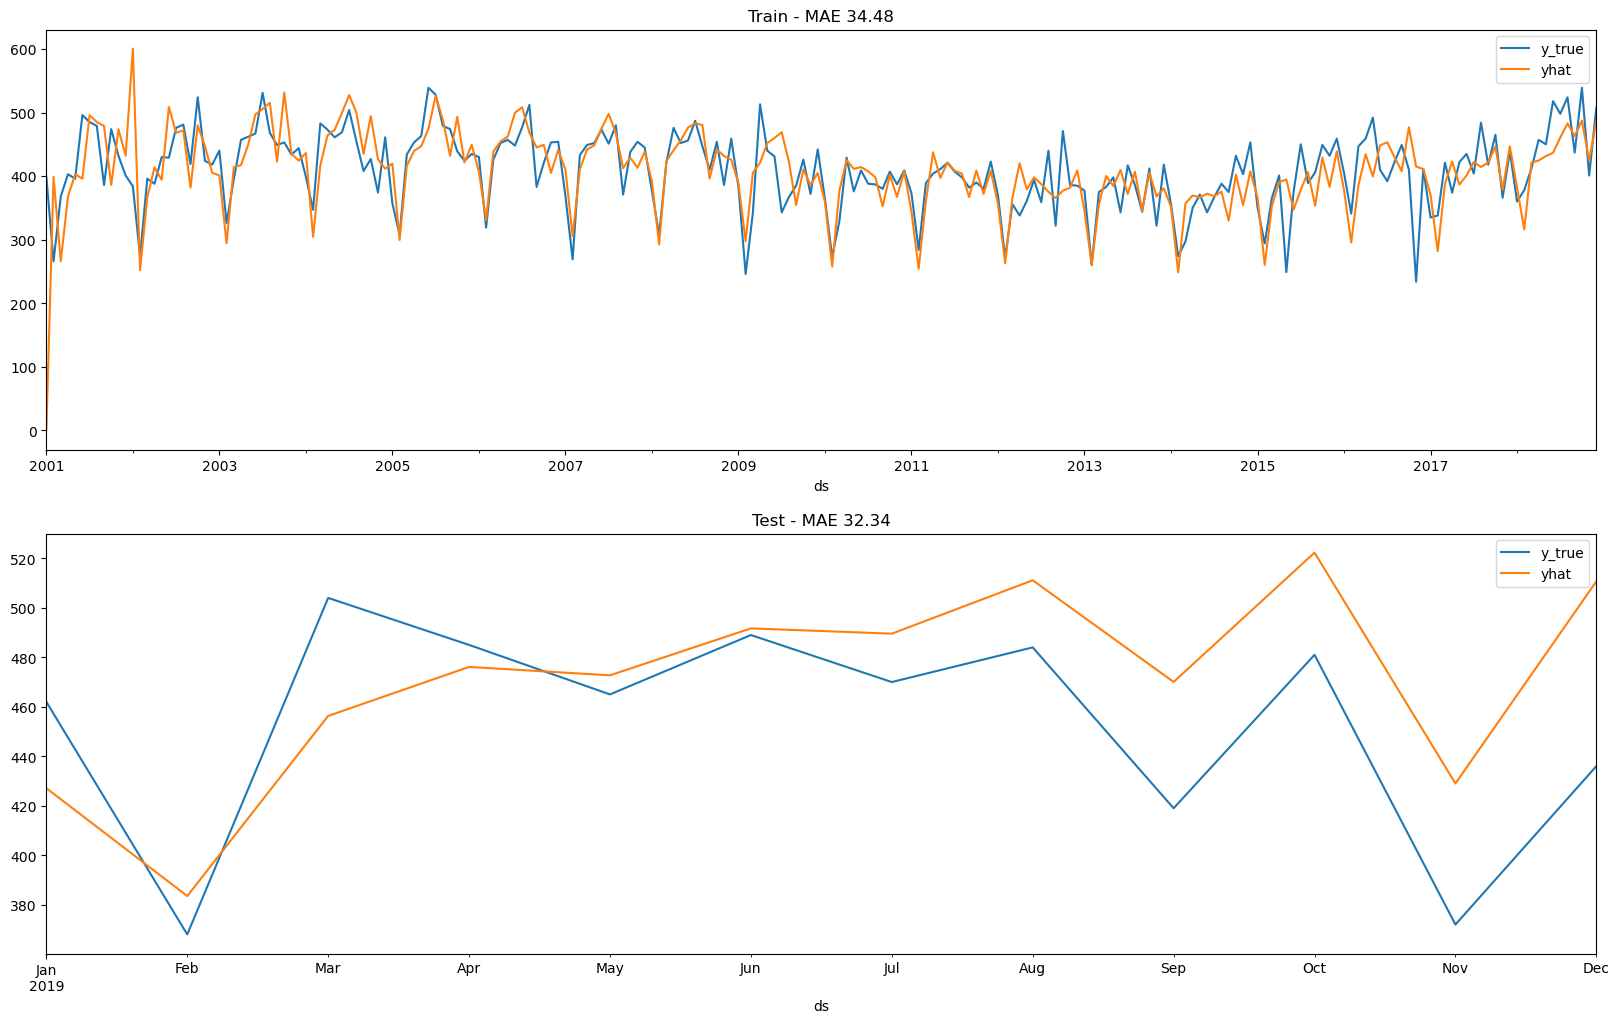

In [13]:
# Evalua metricas de rendimiento en train y test
start_index = 0
end_index = len(train_auto_arima) - 1
yhat_train_sarimax = result_sarimax.predict(start_index, end_index)

start_index = len(train_auto_arima)
end_index = start_index + len(test_auto_arima) - 1
yhat_test_sarimax = result_sarimax.predict(start_index, end_index)

# Reporta resultados
resultados_sarimax = evaluar_desempeno_train_y_test_serie_tiempo(
    train_auto_arima.index,
    train_auto_arima,
    yhat_train_sarimax,
    test_auto_arima.index,
    test_auto_arima,
    yhat_test_sarimax,
    metricas,
)

## XGB


In [14]:
# Agrega los lags significativos segun grafico de autocorrelacion
LAGS_A_AGREGAR = [1, 2, 3, 11, 12, 24]

train_xgb = build_features.add_time_series_columns(train)
train_xgb = build_features.create_lag_features(train_xgb, "n_egresos", LAGS_A_AGREGAR, fill_value=0)

test_xgb = build_features.add_time_series_columns(test)
test_xgb = build_features.create_lag_features(test_xgb, "n_egresos", LAGS_A_AGREGAR, fill_value=0)

# Separa en X e y

X_train_xgb = train_xgb.drop(columns="n_egresos")
y_train_xgb = train_xgb["n_egresos"]

X_test_xgb = test_xgb.drop(columns="n_egresos")
y_test_xgb = test_xgb["n_egresos"]

In [15]:
xgb = XGBRegressor()

param_grid_xgb = {
    "n_estimators": [100, 300, 500, 1000],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring="neg_mean_absolute_error",
    cv=time_splitter,
    verbose=10,
    n_jobs=-1,
)


xgb.fit(X_train_xgb, y_train_xgb)
print(xgb.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


Train
MAE: 11.64
MAPE: 0.03

Test
MAE: 39.66
MAPE: 0.09



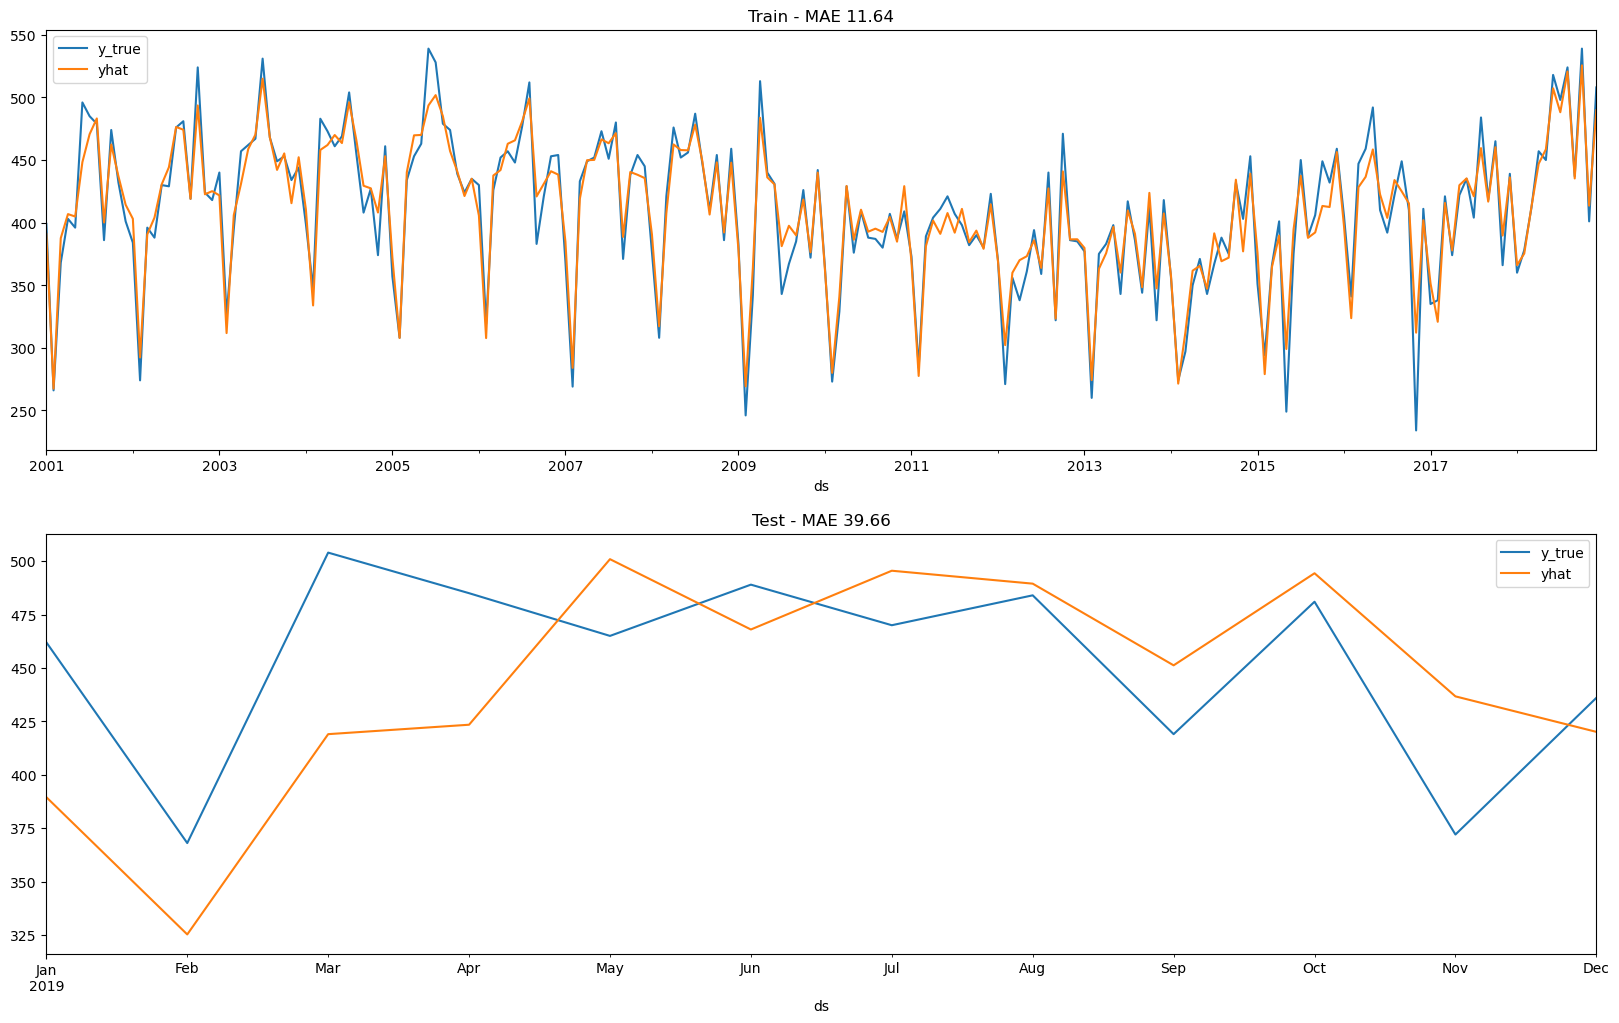

In [16]:
# Evalua metricas de rendimiento en train y test
yhat_train_xgb = xgb.predict(X_train_xgb)
yhat_test_xgb = xgb.predict(X_test_xgb)

# Reporta resultados
resultados_xgb = evaluar_desempeno_train_y_test_serie_tiempo(
    train_xgb.index,
    y_train_xgb,
    yhat_train_xgb,
    test_xgb.index,
    y_test_xgb,
    yhat_test_xgb,
    metricas,
)

## Hibrido

In [17]:
# Preprocesa train
X_1_train_hibrido = DeterministicProcess(index=train.index, order=1, drop=True).in_sample()
ultimo_valor_train = X_1_train_hibrido.iloc[-1, 0]

X_2_train_hibrido = build_features.add_time_series_columns(train)
X_2_train_hibrido = build_features.create_lag_features(
    train_xgb, "n_egresos", LAGS_A_AGREGAR, fill_value=0
).drop(columns="n_egresos")

y_train_hibrido = train["n_egresos"]

X_1_test_hibrido = DeterministicProcess(index=test.index, order=1, drop=True).in_sample()
X_1_test_hibrido = X_1_test_hibrido + ultimo_valor_train

X_2_test_hibrido = build_features.add_time_series_columns(test)
X_2_test_hibrido = build_features.create_lag_features(
    test_xgb, "n_egresos", LAGS_A_AGREGAR, fill_value=0
).drop(columns="n_egresos")

y_test_hibrido = test["n_egresos"]

In [18]:
# Define hiperparametros
param_grid_1 = {"fit_intercept": [True, False]}

param_grid_2 = {
    "max_depth": range(2, 10, 1),
    "n_estimators": range(60, 220, 40),
    "learning_rate": [0.1, 0.01, 0.05],
}

# Define Modelo a entrenar
hibrido = ModeloHibrido(LinearRegression(), XGBRegressor())

In [19]:
hibrido.fit_with_hyperparameter_tuning(
    X_1_train_hibrido, X_2_train_hibrido, y_train_hibrido, param_grid_1, param_grid_2, 5
)

Tuning modelo_1...
Best hyperparameters for modelo_1: {'fit_intercept': True}
CV Results for modelo_1:
  MAE Mean Train Score: -112.2914341360651
  MAE Mean Test Score: -213.102518720486

Tuning modelo_2...
Best hyperparameters for modelo_2: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 60}
CV Results for modelo_2:
  MAE Mean Train Score: -10.074736542835058
  MAE Mean Test Score: -33.64282577318313

Training process completed.


Train
MAE: 6.82
MAPE: 0.02

Test
MAE: 44.07
MAPE: 0.09



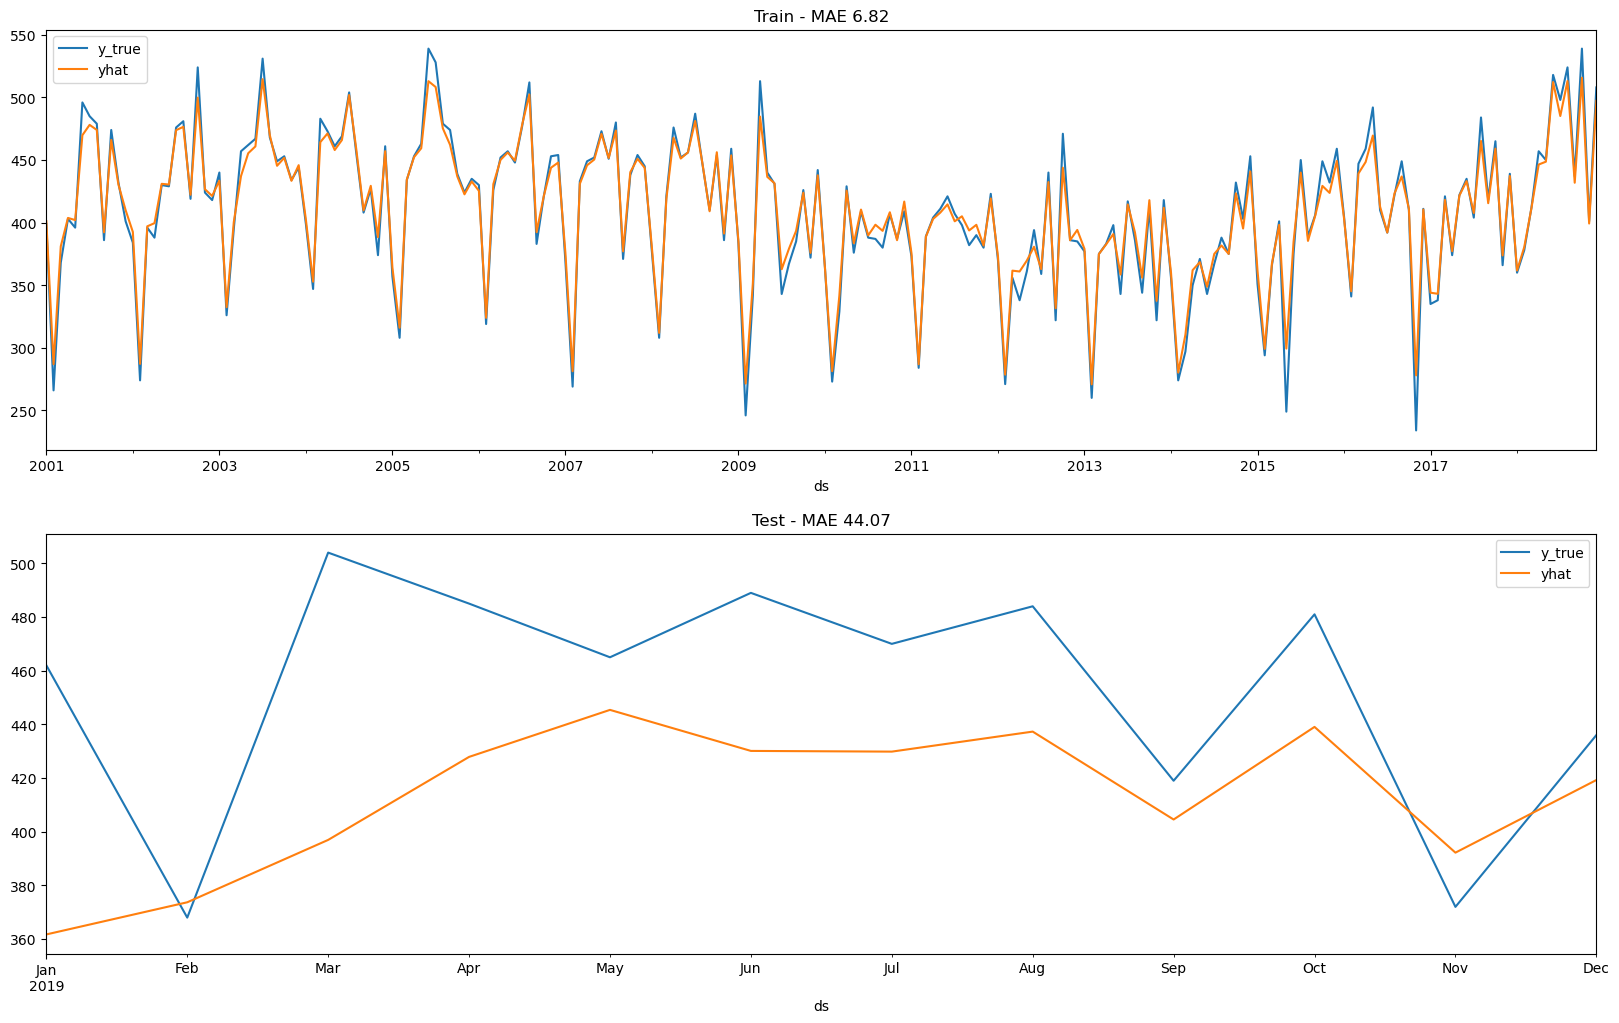

In [20]:
# Evalua metricas de rendimiento en train y test
yhat_train_hibrido = hibrido.predict(X_1_train_hibrido, X_2_train_hibrido)
yhat_test_hibrido = hibrido.predict(X_1_test_hibrido, X_2_test_hibrido)

# Reporta desempeno
resultados_hibrido = evaluar_desempeno_train_y_test_serie_tiempo(
    X_1_train_hibrido.index,
    y_train_hibrido,
    yhat_train_hibrido,
    X_1_test_hibrido.index,
    y_test_hibrido,
    yhat_test_hibrido,
    metricas,
)

## Feed Forward Neural Network


In [21]:
SEQ_SIZE = 3
n_features = 1

train_ff_nn = train.values
test_ff_nn = test.values

X_train_ff_nn, y_train_ff_nn = build_features.to_sequences(train_ff_nn, SEQ_SIZE)
X_test_ff_nn, y_test_ff_nn = build_features.to_sequences(test_ff_nn, SEQ_SIZE)

In [22]:
ff_nn = Sequential(
    [
        Dense(64, activation="relu", input_shape=[SEQ_SIZE]),
        Dense(32, activation="relu"),
        # Dense(32, activation="relu"),
        Dense(1),
    ]
)
ff_nn.compile(loss="mae", optimizer="adam", metrics=["acc"])
print(ff_nn.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2369 (9.25 KB)
Trainable params: 2369 (9.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [23]:
history_ff_nn = ff_nn.fit(
    X_train_ff_nn,
    y_train_ff_nn,
    validation_data=(X_test_ff_nn, y_test_ff_nn),
    epochs=50,
    steps_per_epoch=10,
)

Epoch 1/50


10/10 [==============================] - 1s 19ms/step - loss: 305.9547 - acc: 0.0000e+00 - val_loss: 264.1833 - val_acc: 0.0000e+00
Epoch 2/50
10/10 [==============================] - 0s 5ms/step - loss: 195.9991 - acc: 0.0000e+00 - val_loss: 145.6553 - val_acc: 0.0000e+00
Epoch 3/50
10/10 [==============================] - 0s 5ms/step - loss: 93.9260 - acc: 0.0000e+00 - val_loss: 32.2261 - val_acc: 0.0000e+00
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 55.3487 - acc: 0.0000e+00 - val_loss: 60.0106 - val_acc: 0.0000e+00
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 50.9584 - acc: 0.0000e+00 - val_loss: 26.2553 - val_acc: 0.0000e+00
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 49.8879 - acc: 0.0000e+00 - val_loss: 34.2150 - val_acc: 0.0000e+00
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 47.3896 - acc: 0.0000e+00 - val_loss: 29.0588 - val_acc: 0.0000e+00
Epoch 8/50
10

1/1 [==============================] - 0s 16ms/step
Train
MAE: 44.22
MAPE: 0.12

Test
MAE: 29.79
MAPE: 0.07



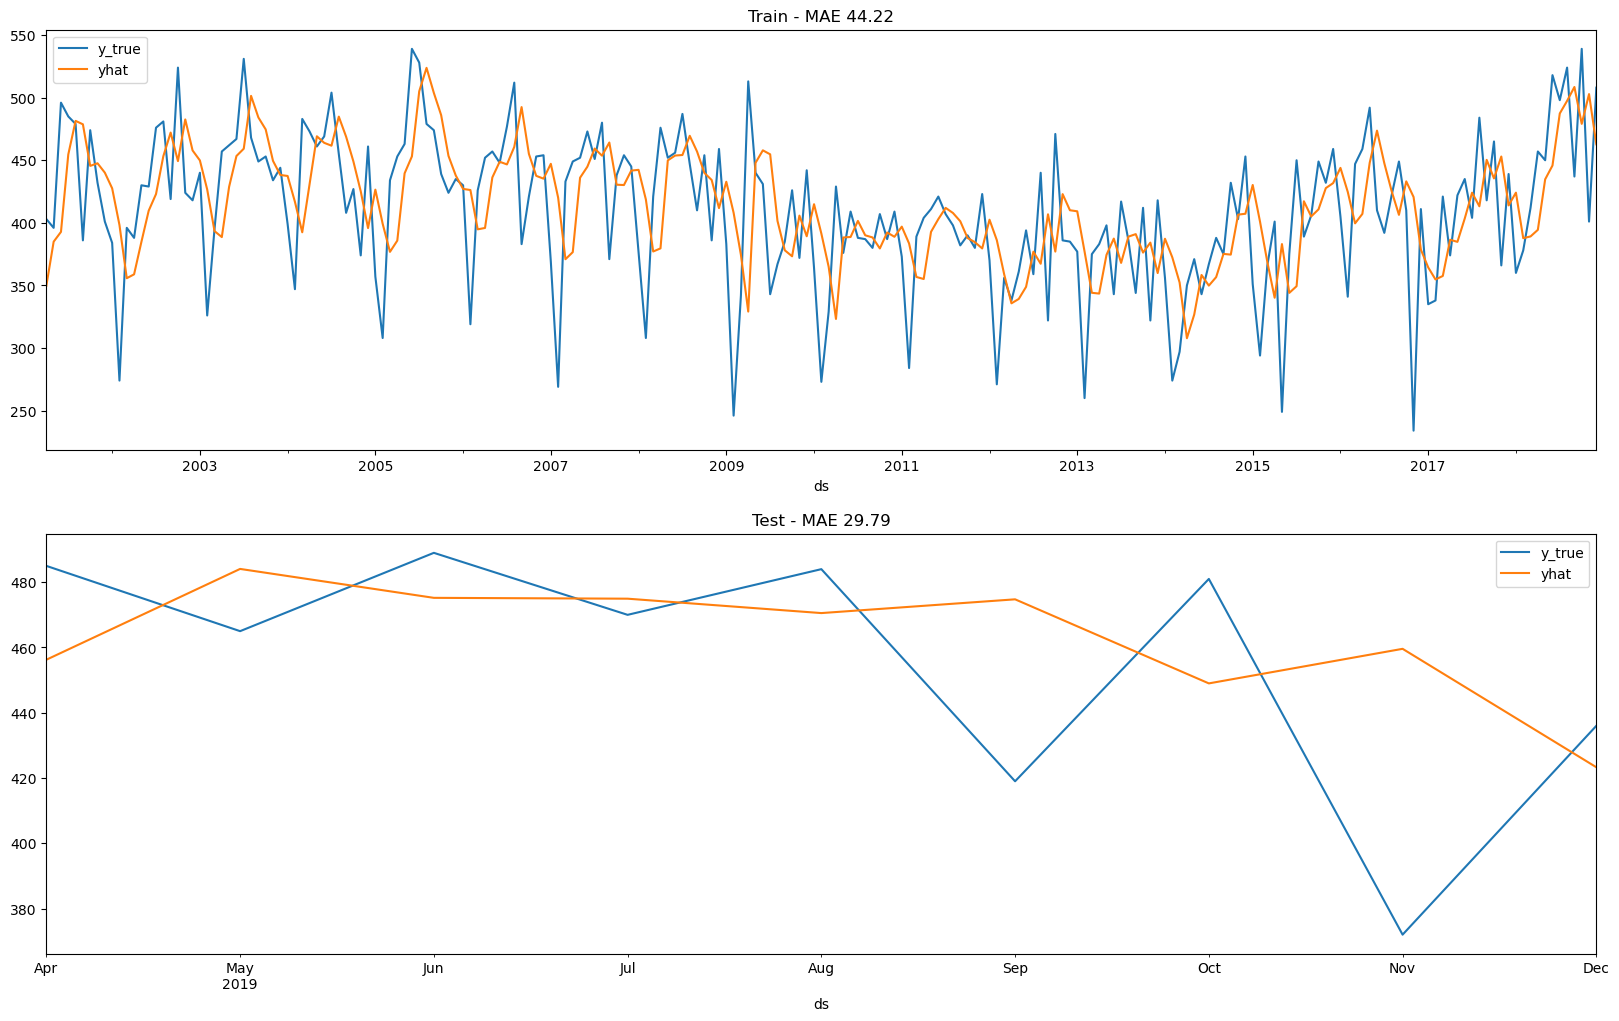

In [24]:
# Evalua metricas de rendimiento en train y test
yhat_train_ff_nn = ff_nn.predict(X_train_ff_nn)
yhat_test_ff_nn = ff_nn.predict(X_test_ff_nn)

# Reporta desempeno
resultados_ff_nn = evaluar_desempeno_train_y_test_serie_tiempo(
    train.iloc[SEQ_SIZE:].index,
    y_train_ff_nn,
    yhat_train_ff_nn.flatten(),
    test.iloc[SEQ_SIZE:].index,
    y_test_ff_nn,
    yhat_test_ff_nn.flatten(),
    metricas,
)

## Long Short Term Memory


In [25]:
SEQ_SIZE = 4
n_features = 1

train_lstm = train.values
test_lstm = test.values

X_train_lstm, y_train_lstm = build_features.to_sequences(train_lstm, SEQ_SIZE)
X_test_lstm, y_test_lstm = build_features.to_sequences(test_lstm, SEQ_SIZE)

X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))

In [26]:
lstm = Sequential(
    [
        LSTM(32, input_shape=(None, SEQ_SIZE), return_sequences=True, activation="relu"),
        LSTM(16, activation="relu"),
        Dense(16),
        Dense(1),
    ]
)

lstm.compile(loss="mae", optimizer="adam")
print(lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          4736      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8161 (31.88 KB)
Trainable params: 8161 (31.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [27]:
history_lstm = lstm.fit(
    X_train_lstm,
    y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=100,
)

Epoch 1/100
7/7 [==============================] - 2s 53ms/step - loss: 389.9554 - val_loss: 383.4716
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 342.5416 - val_loss: 357.6608
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 320.3620 - val_loss: 333.1964
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 296.5526 - val_loss: 303.7134
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 268.6511 - val_loss: 268.6077
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 235.6775 - val_loss: 227.0629
Epoch 7/100
7/7 [==============================] - 0s 8ms/step - loss: 196.5080 - val_loss: 177.8887
Epoch 8/100
7/7 [==============================] - 0s 4ms/step - loss: 151.1470 - val_loss: 119.4090
Epoch 9/100
7/7 [==============================] - 0s 4ms/step - loss: 100.5180 - val_loss: 56.2675
Epoch 10/100
7/7 [==============================] - 0s 8ms/step - loss: 58.3322 - val_loss:

1/1 [==============================] - 0s 11ms/step
Train
MAE: 45.62
MAPE: 0.12

Test
MAE: 30.12
MAPE: 0.07



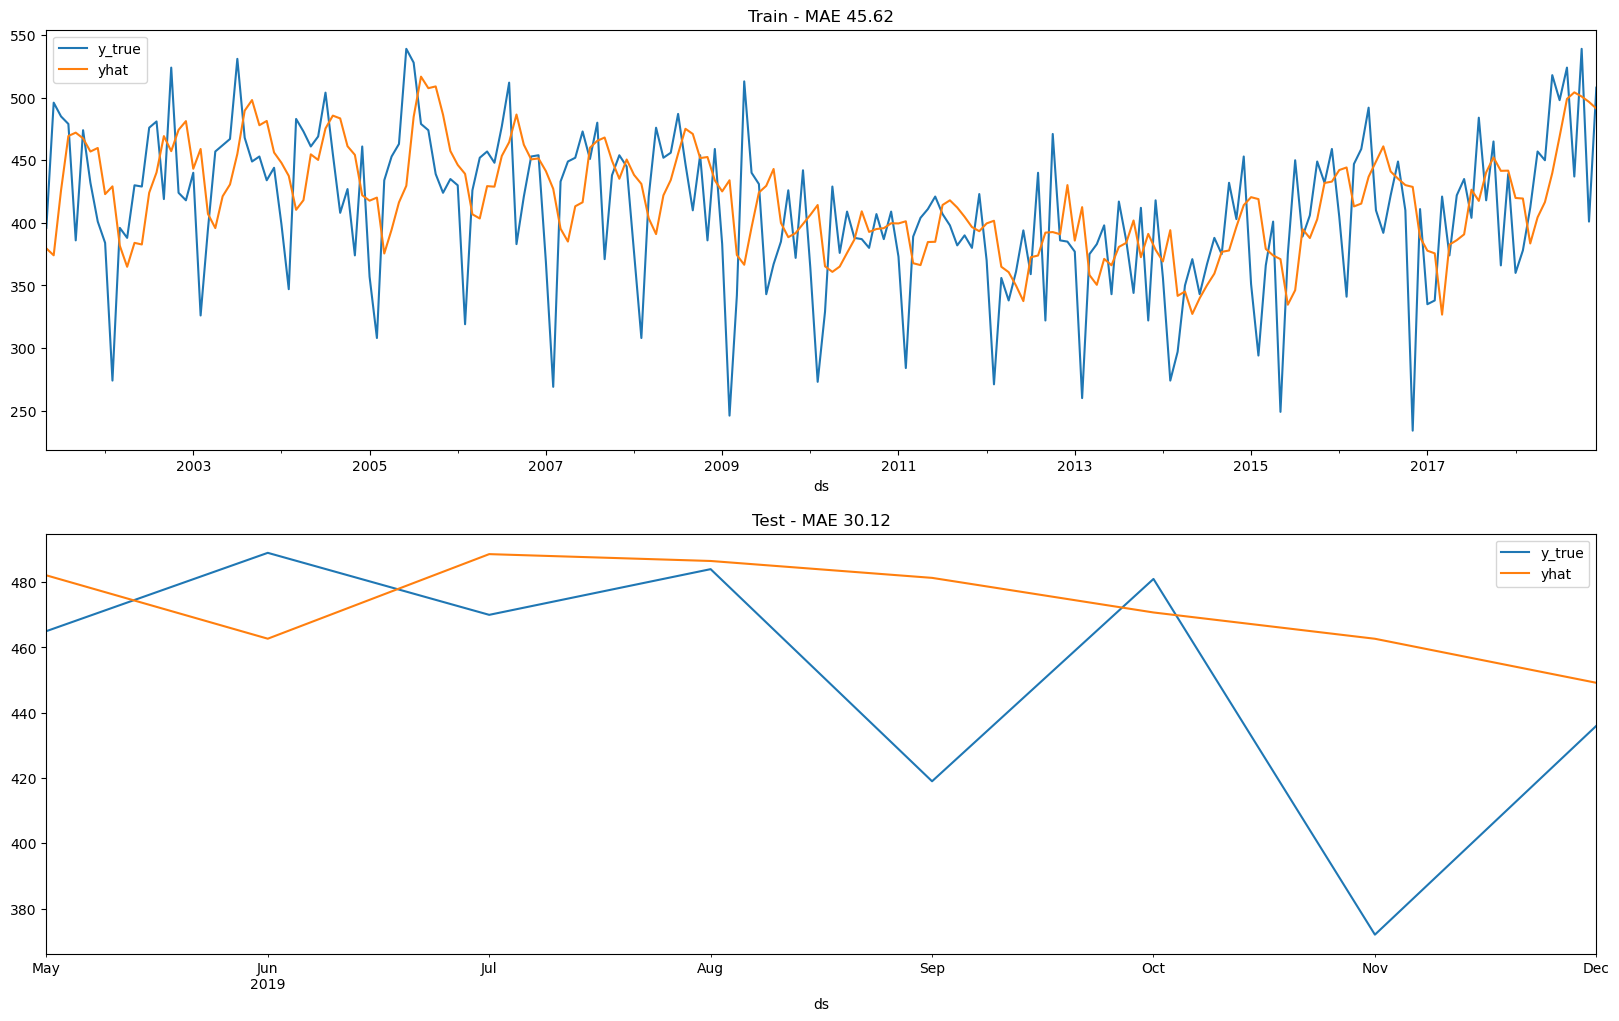

In [28]:
# Evalua metricas de rendimiento en train y test
yhat_train_lstm = lstm.predict(X_train_lstm)
yhat_test_lstm = lstm.predict(X_test_lstm)

# Reporta desempeno
resultados_lstm = evaluar_desempeno_train_y_test_serie_tiempo(
    train.iloc[SEQ_SIZE:].index,
    y_train_lstm,
    yhat_train_lstm.flatten(),
    test.iloc[SEQ_SIZE:].index,
    y_test_lstm,
    yhat_test_lstm.flatten(),
    metricas,
)

## Elección del mejor modelo

Una vez entrenado cada modelo, es posible realizar un resumen de los modelos entrenados.

In [32]:
resultados_totales = {
    "Prophet": resultados_prophet,
    "SARIMAX": resultados_sarimax,
    "XGB": resultados_xgb,
    "Hibrido": resultados_hibrido,
    "FF NN": resultados_ff_nn,
    "LSTM": resultados_lstm,
}

In [33]:
resumen_total = pd.DataFrame()
for nombre_modelo, resultados_modelo in resultados_totales.items():
    resumen_modelo = pd.DataFrame(
        {**resultados_modelo[0], **resultados_modelo[1]}, index=[nombre_modelo]
    )

    resumen_total = pd.concat([resumen_total, resumen_modelo])

display(resumen_total)

,train_MAE,train_MAPE,test_MAE,test_MAPE
Prophet,27.53,0.07,35.46,0.08
SARIMAX,34.48,0.09,32.34,0.07
XGB,11.64,0.03,39.66,0.09
Hibrido,6.82,0.02,44.07,0.09
FF NN,44.22,0.12,29.79,0.07
LSTM,45.62,0.12,30.12,0.07


Observando los resultados, se puede decir que SARIMAX es el mejor modelo para predecir los egresos hospitalarios. Esto, ya que presenta un desempeño similar con el modelo de Feed Forward Network. Sin embargo, el preprocesamiento de los datos tiene una menor complejidad.

# Forecasting Multivariado

En este apartado se quiere realizar un modelo predicitvo que tome en cuenta cada uno de los diagnósticos distintos que existen en el INT. Para esto, se realizará un modelo de previsión multivariado, donde cada uno de las variables será uno de los diagnósticos.

In [238]:
# Transforma los egresos a formato long con cada fecha rellenada
df_multivariado = (
    (
        pd.pivot_table(
            egresos_torax.reset_index(),
            index="FECHA_EGRESO",
            values="n_egresos",
            columns="DIAG1",
            fill_value=0,
            aggfunc="sum",
        )
        .resample("M")
        .sum()
    )
    .reset_index()
    .melt(id_vars="FECHA_EGRESO", value_name="n_egresos")
    .sort_values(["FECHA_EGRESO", "DIAG1"])
)

# Transforma los egresos a formato long con cada fecha rellenada
df_relevantes_multivariado = (
    (
        pd.pivot_table(
            egresos_torax_mas_relevantes.reset_index(),
            index="FECHA_EGRESO",
            values="n_egresos",
            columns="DIAG1",
            fill_value=0,
            aggfunc="sum",
        )
        .resample("M")
        .sum()
    )
    .reset_index()
    .melt(id_vars="FECHA_EGRESO", value_name="n_egresos")
    .sort_values(["FECHA_EGRESO", "DIAG1"])
)

display(df_relevantes_multivariado)

,FECHA_EGRESO,DIAG1,n_egresos
0,2001-01-31,C33X,0
228,2001-01-31,C340,0
456,2001-01-31,C341,0
684,2001-01-31,C342,0
912,2001-01-31,C343,0
...,...,...,...
9347,2019-12-31,Q231,0
9575,2019-12-31,Q676,0
9803,2019-12-31,T820,5
10031,2019-12-31,T821,4


## Separar en train y test

In [239]:
# Separa en train y test para cada diagnostico distinto
train_multivariable = df_relevantes_multivariado[df_relevantes_multivariado["FECHA_EGRESO"] < CORTE_TEST]
test_multivariable = df_relevantes_multivariado[df_relevantes_multivariado["FECHA_EGRESO"] >= CORTE_TEST]

Como ejercicio, haremos la prediccion del proximo mes

## Crear valor y

In [240]:

# Obtiene el valor del siguiente mes para cada uno de los productos
train_multivariable["n_egresos_proximo_mes"] = train_multivariable.groupby("DIAG1")[
    "n_egresos"
].shift(-1)
# Elimina los ultimos meses de los datos
train_multivariable = train_multivariable.dropna()

# Obtiene el valor del siguiente mes para cada uno de los productos
test_multivariable["n_egresos_proximo_mes"] = test_multivariable.groupby("DIAG1")[
    "n_egresos"
].shift(-1)
test_multivariable = test_multivariable.dropna()

display(train_multivariable.tail(20))

,FECHA_EGRESO,DIAG1,n_egresos,n_egresos_proximo_mes
5914,2018-11-30,J398,0,0.0
6142,2018-11-30,J47X,0,3.0
6370,2018-11-30,J679,10,6.0
6598,2018-11-30,J841,7,9.0
6826,2018-11-30,J848,3,9.0
7054,2018-11-30,J849,3,4.0
7282,2018-11-30,J860,8,4.0
7510,2018-11-30,J869,2,3.0
7738,2018-11-30,J90X,5,7.0
7966,2018-11-30,J91X,0,0.0


Los datos quedan hasta el penultimo mes! Esta hecho correctamente

## Crear variables X

In [241]:
# Crea variable lag en train y test
train_multivariable["lag_1"] = train_multivariable.groupby("DIAG1")["n_egresos"].shift(1)
test_multivariable["lag_1"] = test_multivariable.groupby("DIAG1")["n_egresos"].shift(1)

In [242]:
display(train_multivariable.query("DIAG1 == 'C341'"))

,FECHA_EGRESO,DIAG1,n_egresos,n_egresos_proximo_mes,lag_1
456,2001-01-31,C341,0,0.0,NaN
457,2001-02-28,C341,0,1.0,0.0
458,2001-03-31,C341,1,3.0,0.0
459,2001-04-30,C341,3,1.0,1.0
460,2001-05-31,C341,1,0.0,3.0
...,...,...,...,...,...
666,2018-07-31,C341,19,31.0,27.0
667,2018-08-31,C341,31,17.0,19.0
668,2018-09-30,C341,17,15.0,31.0
669,2018-10-31,C341,15,14.0,17.0


In [243]:
# Crea variable diff en train y test
train_multivariable["diff_1"] = train_multivariable.groupby("DIAG1")["n_egresos"].diff(1)
test_multivariable["diff_1"] = test_multivariable.groupby("DIAG1")["n_egresos"].diff(1)

display(train_multivariable.query("DIAG1 == 'C341'"))

,FECHA_EGRESO,DIAG1,n_egresos,n_egresos_proximo_mes,lag_1,diff_1
456,2001-01-31,C341,0,0.0,NaN,NaN
457,2001-02-28,C341,0,1.0,0.0,0.0
458,2001-03-31,C341,1,3.0,0.0,1.0
459,2001-04-30,C341,3,1.0,1.0,2.0
460,2001-05-31,C341,1,0.0,3.0,-2.0
...,...,...,...,...,...,...
666,2018-07-31,C341,19,31.0,27.0,-8.0
667,2018-08-31,C341,31,17.0,19.0,12.0
668,2018-09-30,C341,17,15.0,31.0,-14.0
669,2018-10-31,C341,15,14.0,17.0,-2.0


In [244]:
# Crea rolling variables en train y test
train_multivariable["mean_4"] = (
    train_multivariable.groupby("DIAG1")["n_egresos"]
    .rolling(4)
    .mean()
    .reset_index(level=0, drop=True)
)

test_multivariable["mean_4"] = (
    test_multivariable.groupby("DIAG1")["n_egresos"]
    .rolling(4)
    .mean()
    .reset_index(level=0, drop=True)
)

display(train_multivariable.query("DIAG1 == 'C341'"))

,FECHA_EGRESO,DIAG1,n_egresos,n_egresos_proximo_mes,lag_1,diff_1,mean_4
456,2001-01-31,C341,0,0.0,NaN,NaN,NaN
457,2001-02-28,C341,0,1.0,0.0,0.0,NaN
458,2001-03-31,C341,1,3.0,0.0,1.0,NaN
459,2001-04-30,C341,3,1.0,1.0,2.0,1.00
460,2001-05-31,C341,1,0.0,3.0,-2.0,1.25
...,...,...,...,...,...,...,...
666,2018-07-31,C341,19,31.0,27.0,-8.0,18.50
667,2018-08-31,C341,31,17.0,19.0,12.0,23.75
668,2018-09-30,C341,17,15.0,31.0,-14.0,23.50
669,2018-10-31,C341,15,14.0,17.0,-2.0,20.50


In [245]:
# Pone la fecha como indice
train_multivariable = train_multivariable.set_index("FECHA_EGRESO")
test_multivariable = test_multivariable.set_index("FECHA_EGRESO")

In [246]:
# Agrega variables relacionadas a la fecha
train_multivariable = build_features.add_time_series_columns(train_multivariable)
test_multivariable = build_features.add_time_series_columns(test_multivariable)

## Entrenar modelos

In [247]:
train_multivariable.head(5)

,DIAG1,n_egresos,n_egresos_proximo_mes,lag_1,diff_1,mean_4,quarter,month,year,season,is_leap_year,is_quarter_start,is_quarter_end,days_in_month,holidays_per_month,weekends_per_month,business_days_per_month
FECHA_EGRESO,,,,,,,,,,,,,,,,,
2001-01-31,C33X,0,0.0,NaN,NaN,NaN,1,1,2001,1,0,0,0,31,1,8,23
2001-01-31,C340,0,1.0,NaN,NaN,NaN,1,1,2001,1,0,0,0,31,1,8,23
2001-01-31,C341,0,0.0,NaN,NaN,NaN,1,1,2001,1,0,0,0,31,1,8,23
2001-01-31,C342,0,0.0,NaN,NaN,NaN,1,1,2001,1,0,0,0,31,1,8,23
2001-01-31,C343,0,0.0,NaN,NaN,NaN,1,1,2001,1,0,0,0,31,1,8,23


In [248]:
features = [
    "n_egresos",
    "lag_1",
    "diff_1",
    "mean_4",
    "quarter",
    "month",
    "year",
    "season",
    "is_leap_year",
    "is_quarter_start",
    "is_quarter_end",
    "days_in_month",
    "holidays_per_month",
    "weekends_per_month",
    "business_days_per_month",
]

In [249]:
from sklearn.impute import SimpleImputer

In [250]:
# Impute valores NaN en train y test
imputer = SimpleImputer()
X_train_multivariable = imputer.fit_transform(train_multivariable[features])
y_train_multivariable = train_multivariable["n_egresos_proximo_mes"]

X_test_multivariable = imputer.transform(test_multivariable[features])
y_test_multivariable = test_multivariable["n_egresos_proximo_mes"]

In [251]:
# Entrena modelo
xgb_multivariable = XGBRegressor(
    colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8
)
xgb_multivariable.fit(X_train_multivariable, y_train_multivariable)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [252]:
# Evalua metricas de rendimiento en train y test
yhat_train_xgb_multivariable = xgb_multivariable.predict(X_train_multivariable)
yhat_test_xgb_multivariable = xgb_multivariable.predict(X_test_multivariable)

In [253]:
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [256]:
display(wmape(y_train_multivariable, yhat_train_xgb_multivariable))
display(wmape(y_test_multivariable, yhat_test_xgb_multivariable))

0.5151654694058069

0.5140112804403472